# ACM-DBLP

In [1]:
"""
This script calls functions from modules and completes a whole run for the google amazon dataset
"""

## Preprocess any specific columns (e.g. price column for differnt currency)
## Then get the three types of matrices for both google and amazon data (6 matrices in total)
## Call similarity functions on 3 pairs of matrices
## Concatenate previous results to form the final dataset for modeling
## Call modeling functions (train test split etc)


import sys
sys.path.append('..')
sys.path.append('/anaconda/lib/python3.6/site-packages')
import pandas as pd
import numpy as np
from modules.preprocessing import Preprocessing
from modules.preprocessing.generate_labels import gen_labels
from modules.feature_generation.gen_similarities import similarities
from sklearn.model_selection import train_test_split
from modules.preprocessing import Preprocessor
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score
#import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import itertools

## Run on sample data to find best model using grid search

In [2]:
'''
read data
'''
#df1 = pd.read_csv("data/acm_dblp/full/ACM.csv", engine='python')
#df2 = pd.read_csv("data/acm_dblp/full/DBLP2.csv", engine='python')
#match_df = pd.read_csv("data/acm_dblp/full/DBLP-ACM_perfectMapping.csv")

df1 = pd.read_csv("data/acm_dblp/sample/acm_sample.csv")
df2 = pd.read_csv("data/acm_dblp/sample/dblp_sample.csv")
match_df = pd.read_csv("data/acm_dblp/sample/acm_dblp_sample_match.csv")

In [3]:
'''
specify id names
'''
df1_id = 'id'
df2_id = 'id'
match_id1 = 'idACM' # corresponds to df1_id
match_id2 = 'idDBLP' # corresponds to df2_id

'''
train/test split on input dataset
'''
#random split inputs into train/test using original dataset
df1_train, df1_test = train_test_split(df1, test_size=0.33, random_state=42)


#set index dic
df1_train_index = dict(zip(df1_train[df1_id], df1_train.reset_index().index))
df1_test_index = dict(zip(df1_test[df1_id], df1_test.reset_index().index))

'''
id column manipulation
'''
# save for later use to generate labels
df1_train_id_col = df1_train[df1_id]
df1_test_id_col = df1_test[df1_id]
df2_id_col = df2[df2_id]

match_train = match_df[match_df[match_id1].isin(df1_train_id_col)]
match_test = match_df[match_df[match_id1].isin(df1_test_id_col)]

#drop id columns because we don't need to compute id similarity
df1_train = df1_train.drop(columns = [df1_id])
df1_test = df1_test.drop(columns = [df1_id])
df2 = df2.drop(columns = [df2_id])

print('\tdf1 train shape: ', df1_train.shape, '\n',
      '\tmatch train shape: ', match_train.shape, '\n'
      '\tdf1 test shape: ', df1_test.shape, '\n'
      '\tmatch test shape: ', match_test.shape)

	df1 train shape:  (125, 4) 
 	match train shape:  (110, 2) 
	df1 test shape:  (63, 4) 
	match test shape:  (53, 2)


In [4]:
match_test.head()

,idDBLP,idACM
7,conf/sigmod/HsiaoN00,335461
8,conf/sigmod/SaltenisJLL00,335427
12,conf/sigmod/Mohan99,304230
16,conf/sigmod/LakshmananNHP99,304196
17,conf/sigmod/KanthRSB99,304240


In [5]:
print("***preprocessing***")

processor = Preprocessor(special_columns=['title', 'authors', 'venue'])
processor.fit(df1_train,df2) #fitting on training dataset for input and on whole dataset for ref

processed_train = processor.transform(df1_train, df2)
processed_test = processor.transform(df1_test, df2)

***preprocessing***
**** df1 divide columns ****
numerical_cols :  ['year']
special_field_cols :  ['title' 'authors' 'venue']
word_embedding_cols :  ['title' 'authors' 'venue']

 **** df2 divide columns ****
numerical_cols :  ['year']
special_field_cols :  ['title' 'authors' 'venue']
word_embedding_cols :  ['title' 'authors' 'venue']


/Users/rakshitanagalla/Desktop/capstone-entitymatching/modules/preprocessing/preprocess_special_columns.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[a] = df[a].astype(str)
/Users/rakshitanagalla/Desktop/capstone-entitymatching/modules/preprocessing/preprocess_special_columns.py:109: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return df.astype(str).as_matrix(), None, None
/Users/rakshitanagalla/Desktop/capstone-entitymatching/modules/preprocessing/__init__.py:349: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  df1_numeric = df1_numeric.as_matrix().astype(float)
/Users/rakshitanagalla/Desktop/capstone-entitymatching/modules/preprocessing/__init__.py:350: Future

In [6]:
def gen_x(processed_data):

    '''
    get numerical data
    '''

    num_matrix_1, num_matrix_2 = processed_data["numerical"][0],processed_data["numerical"][1]
    embed_matrix_1, embed_matrix_2 = processed_data["word_embedding_fields"][0],processed_data["word_embedding_fields"][1]
    spc_matrix_1, spc_matrix_2 = processed_data["special_fields"][0],processed_data["special_fields"][1]

    '''
    calculate similarities
    '''

    num_sg_data = similarities().numerical_similarity_on_matrix(num_matrix_1,num_matrix_2,method = "scaled_gaussian")
    num_mm_data = similarities().numerical_similarity_on_matrix(num_matrix_1,num_matrix_2,method = "min_max")
    embed_tfidf_data = similarities().vector_similarity_on_matrix(embed_matrix_1,embed_matrix_2)
    #embed_mean_data = similarities().vector_similarity_on_matrix(embed_matrix_1,embed_matrix_2)
    #embed_min_data = similarities().vector_similarity_on_matrix(embed_matrix_1,embed_matrix_2)
    #embed_max_data = similarities().vector_similarity_on_matrix(embed_matrix_1,embed_matrix_2)
    spc_lav_data = similarities().text_similarity_on_matrix(spc_matrix_1,spc_matrix_2, method = "lavenshtein")
    spc_jw_data = similarities().text_similarity_on_matrix(spc_matrix_1, spc_matrix_2, method="jaro_winkler")
    spc_jc_data = similarities().text_similarity_on_matrix(spc_matrix_1, spc_matrix_2, method="jaccard")
    '''
    concatenate all data
    '''
    # only concatenate non-empty similarity matrices
    non_empty = []

    for m in num_sg_data, num_mm_data, embed_tfidf_data, spc_lav_data, spc_jw_data, spc_jc_data:
        if m.size !=0:
            non_empty.append(m)

    x = np.concatenate([i for i in non_empty], axis = 1)

    print(x.shape)

    return x

In [7]:
'''
generate features
'''
x_train = gen_x(processed_train)
x_test = gen_x(processed_test)

(25000, 14)
(12600, 14)


In [8]:
'''
generate labels
'''
# generate y labels
y_train = gen_labels(df1_train_id_col, df2_id_col, match_train, match_id1, match_id2)

# simple check to see if x and y match in size
print (y_train.shape[0] == x_train.shape[0])
print(y_train.sum() == match_train.shape[0])

# generate y labels
y_test = gen_labels(df1_test_id_col, df2_id_col, match_test, match_id1, match_id2)

# simple check to see if x and y match in size
print (y_test.shape[0] == x_test.shape[0])
print(y_test.sum() == match_test.shape[0])

True
True
True
True


In [9]:
'''
modeling
'''

col_means = np.nanmean(x_train,axis=0)
inds_train  = np.where(np.isnan(x_train))
inds_test = np.where(np.isnan(x_test))
x_train[inds_train]=np.take(col_means, inds_train[1])
x_test[inds_test]=np.take(col_means, inds_test[1])

In [11]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import svm
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=3, scoring='f1')
grid_search.fit(x_train, y_train)
grid_search.best_params_

//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco

{'C': 1, 'gamma': 0.001}

In [13]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {'max_depth': np.arange(3, 10)}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=3, scoring='f1')
grid_search.fit(x_train, y_train)
grid_search.best_params_

{'max_depth': 3}

RF Sample Test-set Score (Old Definition)
	Precision: 0.963
	Recall: 0.981
	F1: 0.972
	Accuracy: 0.9997619047619047
SVC Sample Test-set Score (Old Definition)
	Precision: 0.860
	Recall: 0.925
	F1: 0.891
	Accuracy: 0.9990476190476191
DT Sample Test-set Score (Old Definition)
	Precision: 0.964
	Recall: 1.000
	F1: 0.981
	Accuracy: 0.9998412698412699


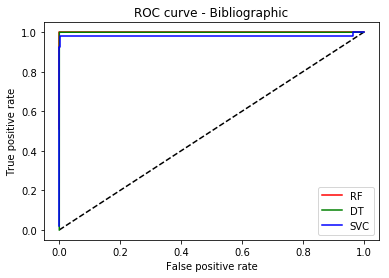

In [14]:
'''
RF
'''
rf_random = RandomForestClassifier(n_estimators=300,
                                   min_samples_split=2,
                                   min_samples_leaf=2,
                                   max_features='sqrt', max_depth=10,
                                   class_weight=None,
                                   bootstrap=False, random_state=42,n_jobs=-1)
rf_random.fit(x_train, y_train)
# predict
y_pred_rf = rf_random.predict(x_test)
y_pred_prob_rf = rf_random.predict_proba(x_test)[:, 1]
# roc curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
# precision, recall, f1
print('RF Sample Test-set Score (Old Definition)')
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_rf))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_rf))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_rf))
print("\tAccuracy: {}".format(sum(y_pred_rf==y_test)/len(y_test)))

'''
SVM
'''
svc_random = svm.SVC(kernel='rbf', C=1, gamma=0.001, random_state=42, probability=True)
svc_random.fit(x_train, y_train)
# predict
y_pred_svc = svc_random.predict(x_test)
y_pred_prob_svc = svc_random.predict_proba(x_test)[:, 1]
# roc curve
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_pred_prob_svc)
# precision, recall, f1
print('SVC Sample Test-set Score (Old Definition)')
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_svc))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_svc))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_svc))
print("\tAccuracy: {}".format(sum(y_pred_svc==y_test)/len(y_test)))

'''
DT
'''
dt_random = DecisionTreeClassifier(max_depth=3, random_state=42)

dt_random.fit(x_train, y_train)
# predict
y_pred_dt = dt_random.predict(x_test)
y_pred_prob_dt = dt_random.predict_proba(x_test)[:, 1]
# roc curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_prob_dt)
# precision, recall, f1
print('DT Sample Test-set Score (Old Definition)')
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_dt))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_dt))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_dt))
print("\tAccuracy: {}".format(sum(y_pred_dt==y_test)/len(y_test)))

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, 'r',label='RF')
plt.plot(fpr_dt, tpr_dt, 'g',label='DT')
plt.plot(fpr_svc, tpr_svc, 'b',label='SVC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Bibliographic')
plt.legend(loc='best')
plt.show()


In [29]:
def gen_orig_labels(pred_df, true_match_df, df1_id_col, match_id1, df2_id_col, match_id2):
    
    match = true_match_df.dropna()
    match['true_label']=1

    mat = pred_df[pred_df['prob']>0.5]
    pred_match = mat.loc[mat.groupby(match_id1)['prob'].idxmax()]
    pred_match['pred_label']=1

    id_ = pd.DataFrame(df1_id_col)
    id_.columns=[match_id1]

    tmp = pred_match.merge(match, how = 'outer')
    tmp = tmp.merge(id_,how='outer')
    tmp['pred_label'] = tmp['pred_label'].fillna(0).astype(int)
    #tmp = tmp.loc[tmp.groupby(match_id1)['pred_label'].idxmin()]

    tmp['true_label'] = tmp['true_label'].fillna(0).astype(int)
    tmp=tmp.drop(columns=['prob'])
    tmp = tmp.sort_values(by=[match_id1])
        
    return tmp

In [513]:
res =[]
for idx, (id_1,id_2) in enumerate(itertools.product(list(df1_test_id_col), list(df2_id_col))):
    res.append([id_1,id_2,y_pred_prob_rf[idx]])

assert(len(res) == len(y_pred_prob_rf))    
pred_match = pd.DataFrame(res, columns=[match_id1,match_id2,'prob'])

In [514]:
result = gen_orig_labels(pred_match, match_test, df1_test_id_col, match_id1, df2_id_col, match_id2)
true_labels = result['true_label']
pred_labels = result['pred_label']

In [515]:
print('RF Sample Test-set Score -- Aligned with Neoway')

print("\tPrecision: %1.3f" % precision_score(true_labels, pred_labels))
print("\tRecall: %1.3f" % recall_score(true_labels, pred_labels))
print("\tF1: %1.3f" % f1_score(true_labels, pred_labels))
#print("\tAccuracy: {}".format(sum(pred==true)/len(true)))

RF Sample Test-set Score -- Aligned with Neoway
	Precision: 0.963
	Recall: 0.981
	F1: 0.972


## Run best model on full datasets

In [16]:
'''
read data
'''
df1 = pd.read_csv("data/acm_dblp/full/ACM.csv", engine='python')
df2 = pd.read_csv("data/acm_dblp/full/DBLP2.csv", engine='python')
match_df = pd.read_csv("data/acm_dblp/full/DBLP-ACM_perfectMapping.csv")

In [17]:
'''
specify id names
'''
df1_id = 'id'
df2_id = 'id'
match_id1 = 'idACM' # corresponds to df1_id
match_id2 = 'idDBLP' # corresponds to df2_id

'''
train/test split on input dataset
'''
#random split inputs into train/test using original dataset
df1_train, df1_test = train_test_split(df1, test_size=0.33, random_state=42)


#set index dic
df1_train_index = dict(zip(df1_train[df1_id], df1_train.reset_index().index))
df1_test_index = dict(zip(df1_test[df1_id], df1_test.reset_index().index))

'''
id column manipulation
'''
# save for later use to generate labels
df1_train_id_col = df1_train[df1_id]
df1_test_id_col = df1_test[df1_id]
df2_id_col = df2[df2_id]

match_train = match_df[match_df['idACM'].isin(df1_train_id_col)]
match_test = match_df[match_df['idACM'].isin(df1_test_id_col)]

#drop id columns because we don't need to compute id similarity
df1_train = df1_train.drop(columns = [df1_id])
df1_test = df1_test.drop(columns = [df1_id])
df2 = df2.drop(columns = [df2_id])

print('\tdf1 train shape: ', df1_train.shape, '\n',
      '\tmatch train shape: ', match_train.shape, '\n'
      '\tdf1 test shape: ', df1_test.shape, '\n'
      '\tmatch test shape: ', match_test.shape)

	df1 train shape:  (1536, 4) 
 	match train shape:  (1483, 2) 
	df1 test shape:  (758, 4) 
	match test shape:  (741, 2)


In [6]:
'''
print("***preprocessing***")

processor = Preprocessor(special_columns=['title', 'authors', 'venue'])
processor.fit(df1_train,df2) #fitting on training dataset for input and on whole dataset for ref

processed_train = processor.transform(df1_train, df2)
processed_test = processor.transform(df1_test, df2)
'''

***preprocessing***
**** df1 divide columns ****
numerical_cols :  ['year']
special_field_cols :  ['title' 'authors' 'venue']
word_embedding_cols :  ['title' 'authors' 'venue']

 **** df2 divide columns ****
numerical_cols :  ['year']
special_field_cols :  ['title' 'authors' 'venue']
word_embedding_cols :  ['title' 'authors' 'venue']


In [9]:
'''
generate features
'''
'''
x_train = gen_x(processed_train)
x_test = gen_x(processed_test)
'''
'''
save features
'''
'''
np.save('acm_dblp_x_train',x_train)
#del x_train

print("***x_train saved***")

np.save('acm_dblp_x_test',x_test)
#del x_test

print("***x_test saved***")
'''

(4018176, 14)
(1982928, 14)
***x_train saved***
***x_test saved***


In [ ]:
'''
load features
'''
x_train = np.load('acm_dblp_x_train.npy')
print("***x_train loaded***")
x_test = np.load('acm_dblp_x_test.npy')
print("***x_test loaded***")

In [18]:
'''
generate labels
'''
# generate y labels
y_train = gen_labels(df1_train_id_col, df2_id_col, match_train, match_id1, match_id2)

# simple check to see if x and y match in size
print (y_train.shape[0] == x_train.shape[0])
print(y_train.sum() == match_train.shape[0])

# generate y labels
y_test = gen_labels(df1_test_id_col, df2_id_col, match_test, match_id1, match_id2)

# simple check to see if x and y match in size
print (y_test.shape[0] == x_test.shape[0])
print(y_test.sum() == match_test.shape[0])

True
True
True
True


In [19]:
#get validation set
x_train_new, x_val, y_train_new, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.15, random_state=42)
print(sum(y_train_new))
print(sum(y_val))
del x_train
del y_train

1261
222


In [20]:
#impute
col_means = np.nanmean(x_train_new,axis=0)
inds_train  = np.where(np.isnan(x_train_new))
inds_val = np.where(np.isnan(x_val))
x_train_new[inds_train]=np.take(col_means, inds_train[1])
x_val[inds_val]=np.take(col_means, inds_val[1])

In [14]:
'''
modeling
'''
#using hyperparameters found by gridsearch in previous section
rf_random = RandomForestClassifier(n_estimators=300,
                                   min_samples_split=2,
                                   min_samples_leaf=2,
                                   max_features='sqrt', max_depth=10,
                                   class_weight=None,
                                   bootstrap=False, random_state=42,n_jobs=-1)
rf_random.fit(x_train_new, y_train_new)

print("training score")
# predict
y_pred_rf = rf_random.predict(x_train_new)
y_pred_prob_rf = rf_random.predict_proba(x_train_new)[:, 1]
# roc curve
fpr_rf, tpr_rf, _ = roc_curve(y_train_new, y_pred_prob_rf)
# precision, recall, f1
print('RF')
print("\tPrecision: %1.3f" % precision_score(y_train_new, y_pred_rf))
print("\tRecall: %1.3f" % recall_score(y_train_new, y_pred_rf))
print("\tF1: %1.3f" % f1_score(y_train_new, y_pred_rf))
print("\tAccuracy: {}".format(sum(y_pred_rf==y_train_new)/len(y_train_new)))
del x_train_new

print("val score")
# predict
y_pred_rf = rf_random.predict(x_val)
y_pred_prob_rf = rf_random.predict_proba(x_val)[:, 1]
# roc curve
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_prob_rf)
# precision, recall, f1
print('RF')
print("\tPrecision: %1.3f" % precision_score(y_val, y_pred_rf))
print("\tRecall: %1.3f" % recall_score(y_val, y_pred_rf))
print("\tF1: %1.3f" % f1_score(y_val, y_pred_rf))
print("\tAccuracy: {}".format(sum(y_pred_rf==y_val)/len(y_val)))
del x_val

training score
RF
	Precision: 0.997
	Recall: 0.993
	F1: 0.995
	Accuracy: 0.9999961937654464
val score
RF
	Precision: 0.995
	Recall: 0.977
	F1: 0.986
	Accuracy: 0.9999900452443644


**no overfitting, so evaluate on test**

In [29]:
#impute nan's
inds_test = np.where(np.isnan(x_test))
x_test[inds_test]=np.take(col_means, inds_test[1])

print(y_test.shape[0] == x_test.shape[0])

print("test score")
# predict
y_pred_rf = rf_random.predict(x_test)
y_pred_prob_rf = rf_random.predict_proba(x_test)[:, 1]
# roc curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
# precision, recall, f1
print('RF')
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred_rf))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred_rf))
print("\tF1: %1.3f" % f1_score(y_test, y_pred_rf))
print("\tAccuracy: {}".format(sum(y_pred_rf==y_test)/len(y_test)))

True
test score
RF
	Precision: 0.982
	Recall: 0.980
	F1: 0.981
	Accuracy: 0.9999858794671315


In [30]:
print("num of true matches")
print(sum(y_test))

num of true matches
741


In [31]:
print("num of predicted matches")
print(sum(y_pred_rf))

num of predicted matches
739


In [27]:
res =[]
for idx, (id_1,id_2) in enumerate(itertools.product(list(df1_test_id_col), list(df2_id_col))):
    res.append([id_1,id_2,y_pred_prob_rf[idx]])
pred_match = pd.DataFrame(res, columns=[match_id1,match_id2,'prob'])

In [30]:
result = gen_orig_labels(pred_match, match_test,df1_test_id_col, match_id1, df2_id_col, match_id2)
true = result['true_label']
pred = result['pred_label']

In [31]:
print('RF Full Data Test-set Score -- Aligned with Neoway')

print("\tPrecision: %1.3f" % precision_score(true, pred))
print("\tRecall: %1.3f" % recall_score(true, pred))
print("\tF1: %1.3f" % f1_score(true, pred))
print("\tAccuracy: {}".format(sum(pred==true)/len(true)))

RF Full Data Test-set Score -- Aligned with Neoway
	Precision: 0.992
	Recall: 0.976
	F1: 0.984
	Accuracy: 0.9685452162516383


In [28]:
# save the classifier
'''
import pickle
with open('acm_dblp_rf.pkl', 'wb') as fid:
    pickle.dump(rf_random, fid, protocol=4)

print("***model saved***")
'''

***model saved***
